# Extraction and exploration of Cognite OID

In [1]:
# Imports
# %pip install seaborn
from publicdata import client as c
from functions import *
from datetime import datetime, timezone
from scipy.stats import norm

/home/fredrik/time_series_gan_project/functions.py:118: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if norm is "log":


In [2]:
# Nine sensors related to the inputs, outputs and controls of a compressor subsystem.
# Dictionary made with key=name of sensor and value=Id of sensor
sensors = {
    'PDT-92534':6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':7638223843994790,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}
# I'll extract a pandas dataframe for each of the sensors in sensor_names, and these will be stored
# in the following dictionary, again with the sensor name as the key.
dfs_dict = {}

startdate = datetime(2018, 11, 5, tzinfo=timezone.utc)
enddate = datetime(2018, 11, 14, tzinfo=timezone.utc)


In [3]:

# Extract dataframes from Cognite OID and store them in the dfs_dict dictionary
for k, v in sensors.items():
    res = c.time_series.data.retrieve_dataframe(id=v, 
                                                start=startdate, 
                                                end=enddate, 
                                                column_names='id')
    # res.index = res.index.strftime("%d/%m/%Y, %H:%M:%S")
    dfs_dict[k] = res
    print(f'Sensor {k} imported')

# Functions to plot one or all sensors
# plot_sensor_data('PDT-92534', dfs_dict)
# plot_all_nine_sensors(dfs_dict)


Sensor PDT-92534 imported
Sensor PT-92523 imported
Sensor TIC-92504 imported
Sensor TT 92532 imported
Sensor FT-92537 imported
Sensor TT-92539 imported
Sensor PT-92539 imported
Sensor ZT 92543 imported
Sensor KA 9101 imported


In [4]:
# Inspect the start of each sensors time series
for name, df in dfs_dict.items():
    print(df.head())

                         6908033636680653
2018-11-05 00:00:00.343        103.648430
2018-11-05 00:00:02.343        103.859009
2018-11-05 00:00:04.343        103.227280
2018-11-05 00:00:06.343        102.595558
2018-11-05 00:00:07.338        101.542686
                         8877482139815959
2018-11-05 00:00:00.058          2.800061
2018-11-05 00:00:01.058          2.796201
2018-11-05 00:00:03.058          2.792340
2018-11-05 00:00:04.058          2.784619
2018-11-05 00:00:05.058          2.780758
                         7012228881452176
2018-11-05 00:00:00.343         39.624779
2018-11-05 00:00:01.343         39.619896
2018-11-05 00:00:03.343         39.624779
2018-11-05 00:00:04.343         39.629665
2018-11-05 00:00:06.343         39.634548
                         8152209984966682
2018-11-05 00:00:14.073         33.946278
2018-11-05 00:00:19.073         33.973137
2018-11-05 00:00:34.073         33.946278
2018-11-05 00:00:54.073         33.919415
2018-11-05 00:01:09.073         33

### Simple inspection of the data

In [5]:
def strip_time(df, idx):
    return df.index[idx]


print("Name".ljust(12) + "First period".ljust(15) + "Second period".ljust(15) + "Third period".ljust(15) + "Average period".ljust(15))
for name, df in dfs_dict.items():
    idx0 = strip_time(df, 0)
    idx1 = strip_time(df, 1)
    idx2 = strip_time(df, 2)
    idx3 = strip_time(df, 3)
    idx_last = strip_time(df, -1)
    f_per = (idx1 - idx0).total_seconds()
    second_per = (idx2 - idx1).total_seconds()
    third_per = (idx3 - idx2).total_seconds()
    avg_per = ((idx_last - idx0)/df.shape[0]).total_seconds()
    print(name.ljust(12) + str(f_per).ljust(15) + str(second_per).ljust(15) + str(third_per).ljust(15) + str(avg_per).ljust(15))


Name        First period   Second period  Third period   Average period 
PDT-92534   2.0            2.0            2.0            1.167216       
PT-92523    1.0            2.0            1.0            1.355685       
TIC-92504   1.0            2.0            1.0            1.35918        
TT 92532    5.0            15.0           20.0           13.224134      
FT-92537    1.0            1.0            1.0            1.029559       
TT-92539    1.031          0.969          16.0           6.74694        
PT-92539    2.0            1.0            2.995          1.407098       
ZT 92543    5.0            5.0            5.0            7.187255       
KA 9101     5.0            5.0            5.0            5.265898       


The sampling rate is very different between the sensors, but also varying over time. Therefore, the choose to data is imported as 30 seconds time aggregates, meaning all samples within each 30 second period is averaged.

In [6]:
# Extract dataframes from Cognite OID and store them in the dfs_dict dictionary
for k, v in sensors.items():
    res = c.time_series.data.retrieve_dataframe(id=v, 
                                                start=startdate, 
                                                end=enddate, 
                                                column_names='id',
                                                aggregates=["average"],
                                                granularity="30s",)
    dfs_dict[k] = res
    print(f'Sensor {k} imported')

Sensor PDT-92534 imported
Sensor PT-92523 imported
Sensor TIC-92504 imported
Sensor TT 92532 imported
Sensor FT-92537 imported
Sensor TT-92539 imported
Sensor PT-92539 imported
Sensor ZT 92543 imported
Sensor KA 9101 imported


In [7]:
#We see above that the average period is longer than 30 seconds, meaning some datapoints are missing. Need to figure out how long these period of missing data are.
longest_period = {}
for name, df in dfs_dict.items():
    df_len = df.shape[0]
    l_period = 0
    for i in range(df_len-1):
        per = (strip_time(df, i + 1)- strip_time(df, i)).total_seconds()
        if (per > l_period):
            l_period = per
        if per > 320:
            print(f'Time series {name}: {strip_time(df, i)}')
    longest_period[name] = l_period

print(longest_period)

Time series TT 92532: 2018-11-11 02:15:00
{'PDT-92534': 300.0, 'PT-92523': 300.0, 'TIC-92504': 300.0, 'TT 92532': 330.0, 'FT-92537': 300.0, 'TT-92539': 300.0, 'PT-92539': 300.0, 'ZT 92543': 300.0, 'KA 9101': 300.0}


### Standardizing the data

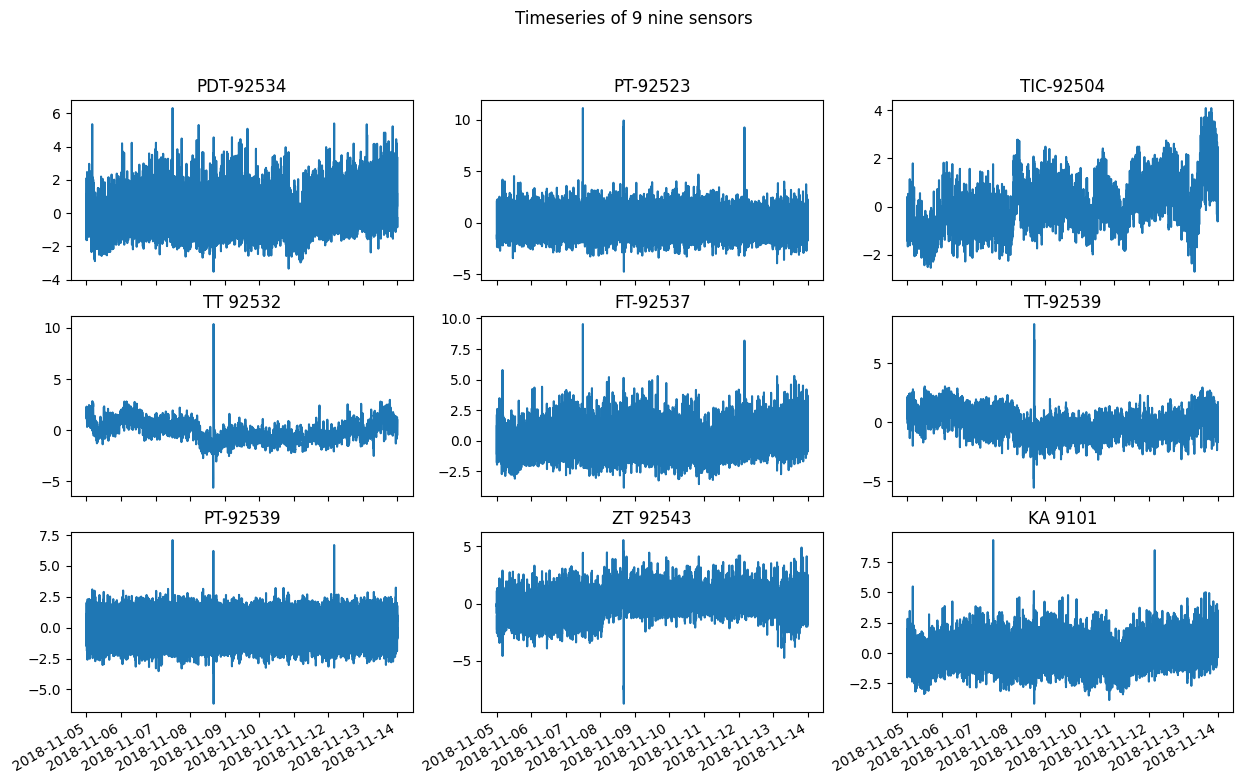

In [8]:
standard_df = standardize_dfs(dfs_dict)

plot_all_nine_sensors(dataframe=standard_df)

### Compile and plot histograms for each sensor

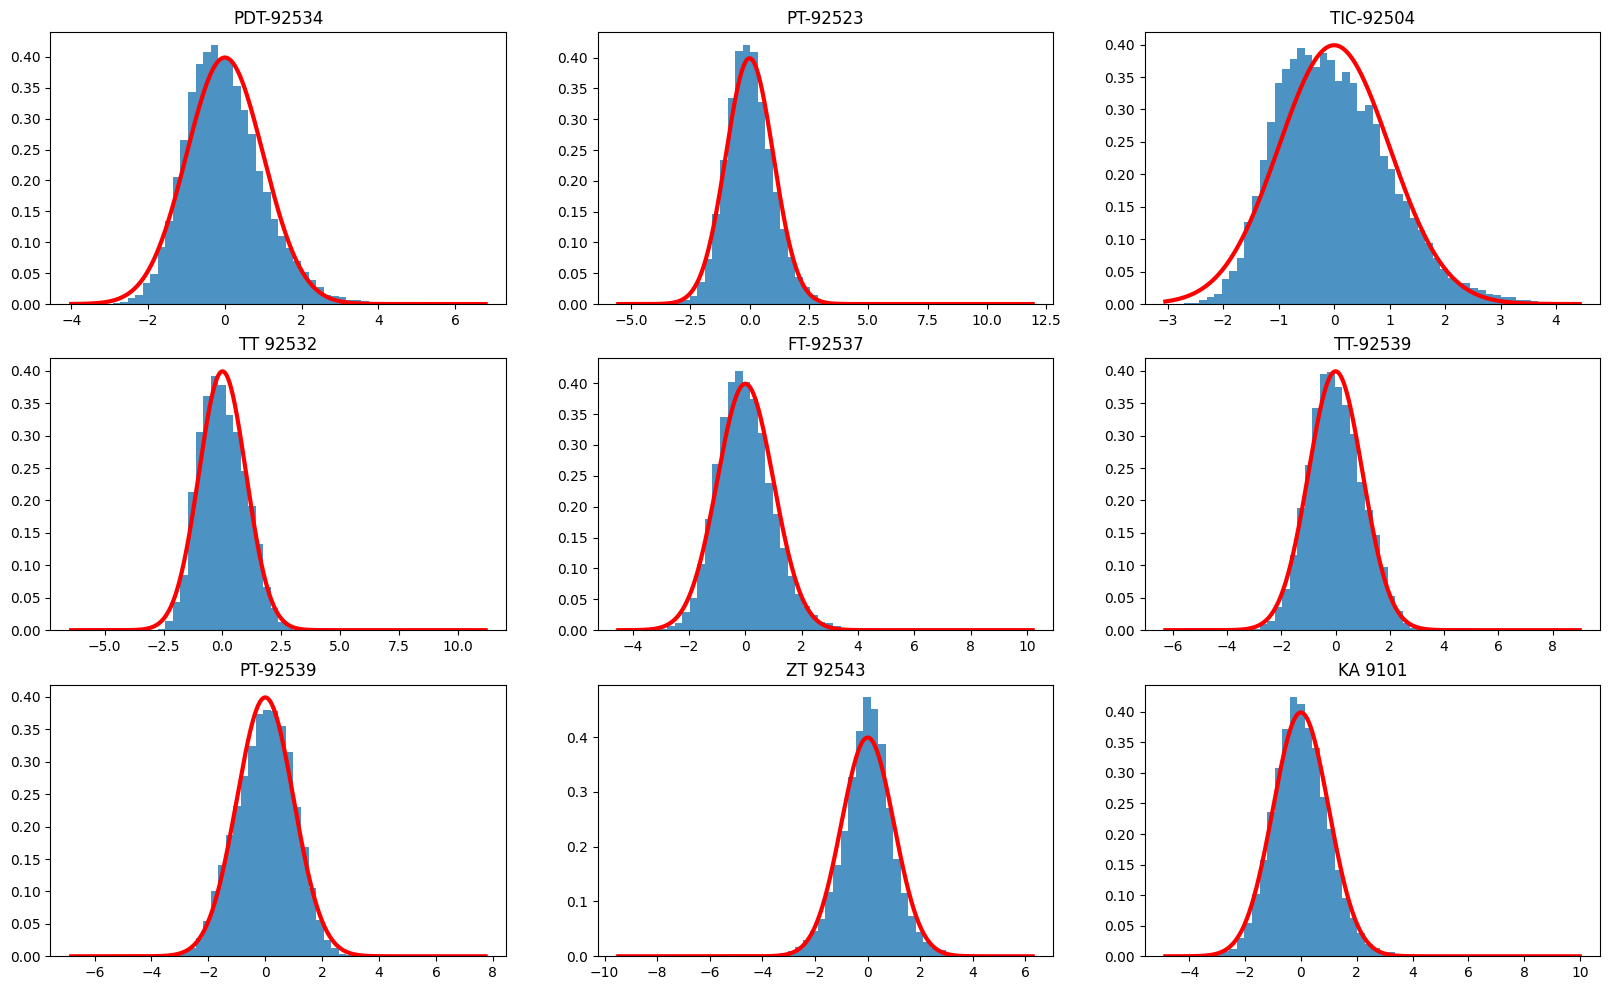

In [9]:
#Plot histograms
#Using standardized values
names = list(standard_df.keys())
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
bins = 50

m=0
for i in range(3):
    for j in range(3):
        ax[i,j].hist(standard_df[names[m]], bins = bins, density=True, alpha=0.8)
        avg, std = norm.fit(standard_df[names[m]])
        xmin, xmax = ax[i,j].get_xlim() 
        x = np.linspace(xmin, xmax, 500) 
        p = norm.pdf(x, avg, std) 
  
        ax[i,j].plot(x, p, 'r', linewidth=3) 
        ax[i,j].set_title(names[m])
        m+=1

plt.show()


### Finding KL divergence by comparing histograms [Not used in report]


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
[[0.0, inf, 0.12201403861906397, inf, inf, inf, inf, inf, inf], [inf, 0.0, 0.5455971228928216, inf, inf, inf, inf, inf, inf], [inf, inf, 0.0, inf, inf, inf, inf, inf, inf], [inf, inf, 0.4886307505252903, 0.0, inf, inf, inf, inf, inf], [inf, inf, 0.47017154652823134, inf, 0.0, inf, inf, inf, inf], [inf, inf, 0.3869775700259654, inf, inf, 0.0, inf, inf, inf], [inf, inf, 0.49782241719369413, inf, inf, inf, 0.0, inf, inf], [inf, inf, 1.4811147293314, inf, inf, inf, inf, 0.0, inf], [inf, inf, 0.39048909504644913, 0.3976357626212287, inf, inf, inf, inf, 0.0]]


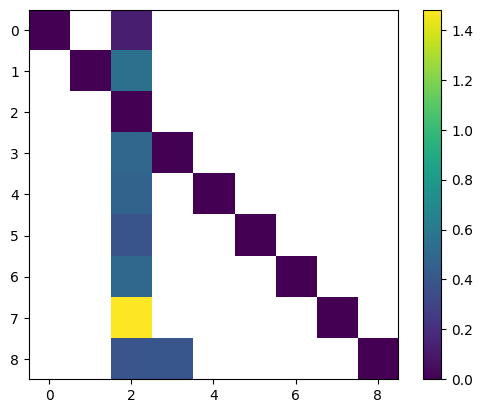

In [10]:
%pip install scipy
KL = []

i = 0
j = 0

for name, df in standard_df.items():
    row = []
    hist1 = np.histogram(df, bins=bins)[0]
    hist1 = hist1/sum(hist1)
    for name2, df2 in standard_df.items():
        hist2 = np.histogram(df2, bins=bins)[0]
        hist2 = hist2/sum(hist2)
        # print(f'H1: {type(hist1)}, H2: {type(hist2)}')
        row.append(entropy(hist1, hist2))
    KL.append(row)

print(KL)
im = plt.imshow(KL)
plt.colorbar(im)
plt.show()

### Finding KL divergence from mean and std

We assume that each sensors samples comes from a univariate normal distribution with mean $\mu$ and standard deviation $\sigma$, we can estimate $\mu$ and $\sigma$ from the sample date. We can thn find the KL divergence between 2 estimated distributions by the following formula

$$KL(\mathcal{N}_1(\mu_1, \sigma_1)||\mathcal{N}_2(\mu_2, \sigma_2)) = log(\frac{\sigma_2}{\sigma_1}) + \frac{\sigma_1^2 +(\mu_1-\mu_2)^2}{2 \sigma_2^2}-\frac{1}{2}$$

In [11]:
# Test the function
mu, sigma = 1, 2
mu2, sigma2 = 0, 2

print(f'Using mean and std directly: KL={KL_with_params(mu, sigma, mu2, sigma2)}')

Using mean and std directly: KL=0.125


Since this method assumes the mean and standard deviation comes from actual normal distributions, standardizing the samples would make all the sample distributions look identical. We therefore have to us unstandardized values with this KL divergence method. Since it's just estimates of mean and standard deviation, the computed KL divergence will not be the actual KL divergence between the sensors behavior, but rather the KL divergence between the sensors estimated source distributions.

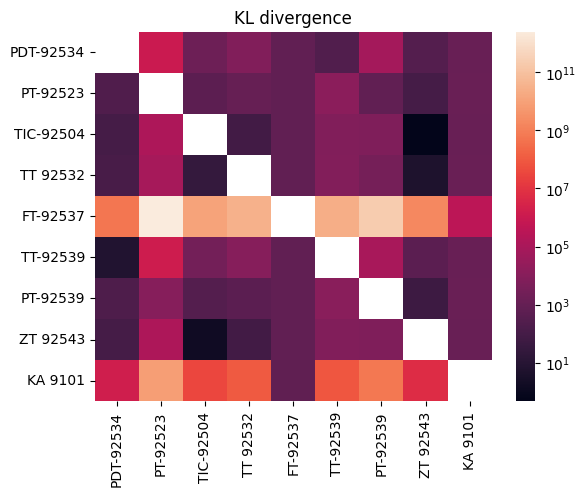

In [12]:
KL2 = kl_dfs(dfs_dict)
plot_kl(KL2, norm='log', axis_labels=dfs_dict.keys())

### Correlation between sensors

           PDT-92534  PT-92523  TIC-92504  TT 92532  FT-92537  TT-92539  \
PDT-92534   1.000000  0.017063   0.422030  0.062911  0.595574 -0.026824   
PT-92523    0.017063  1.000000   0.032411 -0.029126  0.029181  0.015332   
TIC-92504   0.422030  0.032411   1.000000 -0.187456  0.306142 -0.280469   
TT 92532    0.062911 -0.029126  -0.187456  1.000000  0.026096  0.422649   
FT-92537    0.595574  0.029181   0.306142  0.026096  1.000000 -0.030283   

           PT-92539  ZT 92543   KA 9101  
PDT-92534 -0.072652  0.039340  0.247319  
PT-92523   0.523222 -0.005012 -0.044079  
TIC-92504  0.076513  0.248798  0.266106  
TT 92532   0.006841 -0.304961  0.055963  
FT-92537   0.130852  0.036821  0.197868  


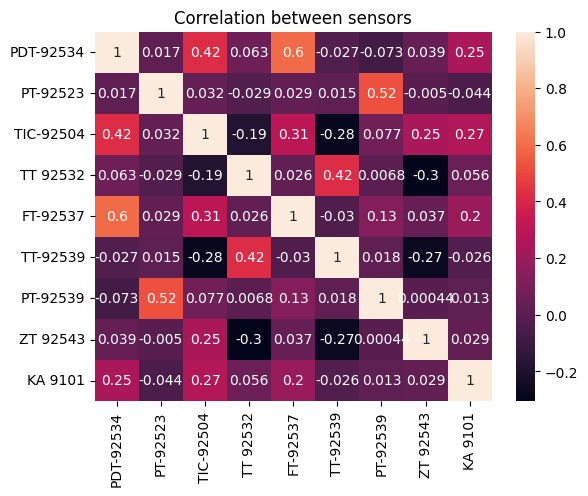

In [13]:
# %pip install jinja2
correlate_dfs(dfs_dict)

### Reshape all time series to same length

/home/fredrik/time_series_gan_project/functions.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_df = reshape_df(df).fillna(method='ffill')


Original shape: (25771, 1) Resampled shape: (25920, 1)
Original shape: (25770, 1) Resampled shape: (25920, 1)
Original shape: (25770, 1) Resampled shape: (25920, 1)
Original shape: (23448, 1) Resampled shape: (25920, 1)
Original shape: (25765, 1) Resampled shape: (25920, 1)
Original shape: (24189, 1) Resampled shape: (25920, 1)
Original shape: (25770, 1) Resampled shape: (25920, 1)
Original shape: (24872, 1) Resampled shape: (25920, 1)
Original shape: (25746, 1) Resampled shape: (25920, 1)
Reshaping done


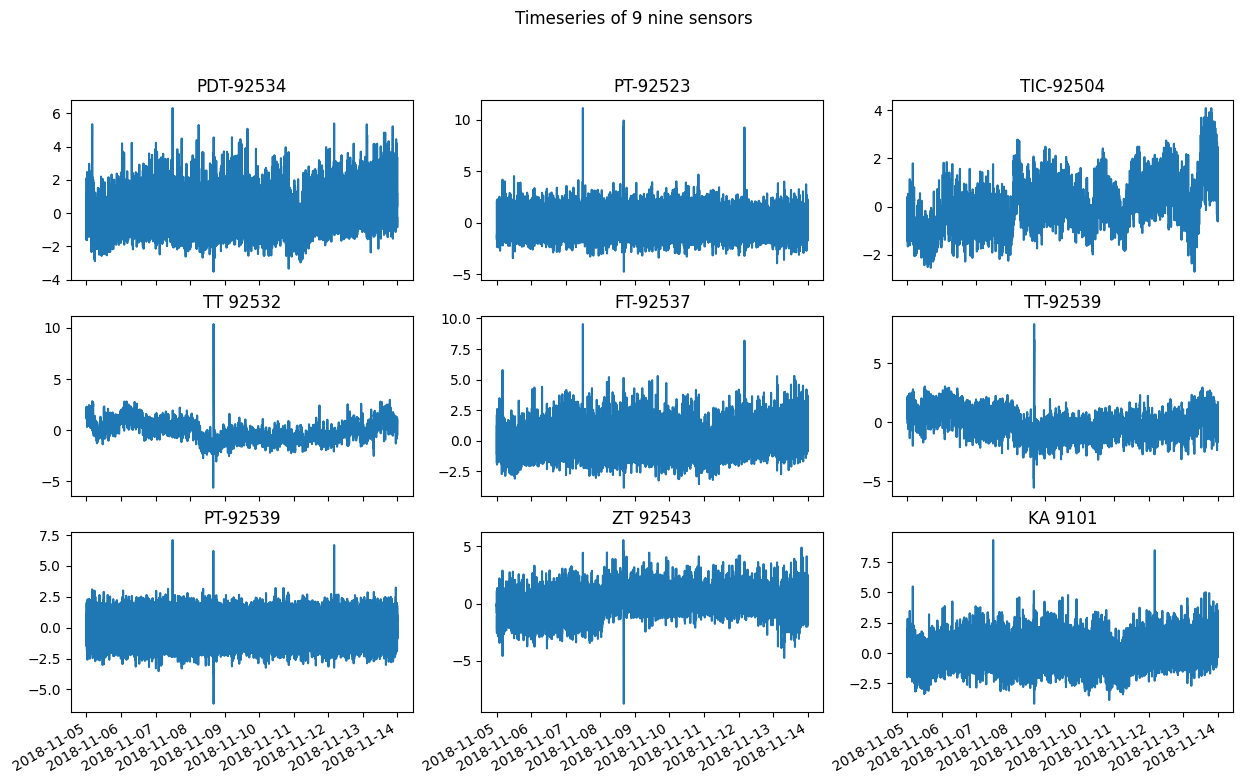

In [14]:
reshaped_dfs = reshape_dfs(standard_df)

plot_all_nine_sensors(reshaped_dfs)


## Checking for global trends in the data

/tmp/ipykernel_7616/1121205051.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, cols, index)


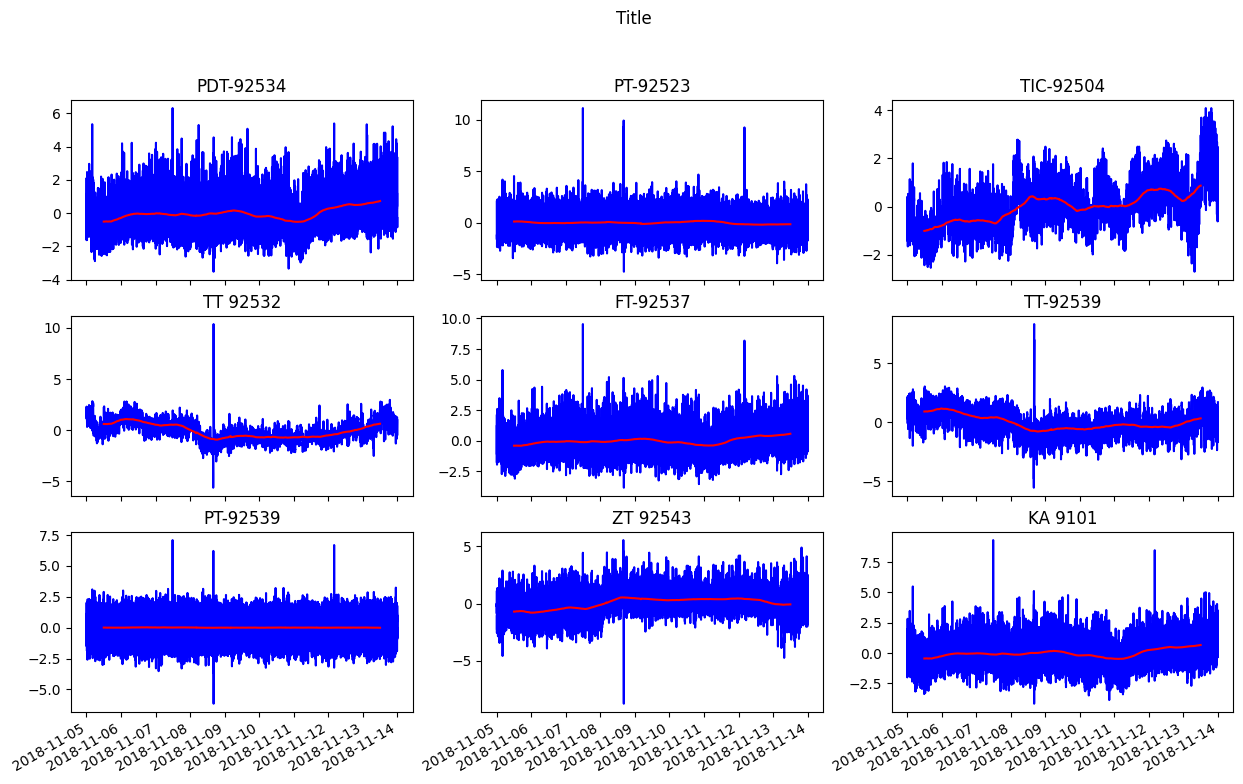

In [15]:
# %pip install statsmodels
import statsmodels.api as sm

title = 'Title'

plt.figure(figsize=(15, 9))
plt.suptitle(title)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
rows = 3
cols = 3
n = rows * cols
index = 1

for name, df in reshaped_dfs.items():
    plt.subplot(rows, cols, index)
    index += 1
    decomp = sm.tsa.seasonal_decompose(df, period = 2*60*24)
    plt.plot(df, c='blue')
    plt.plot(decomp.trend.index, decomp.trend, c='red')
    plt.gcf().autofmt_xdate()
    plt.title(name)
plt.show()

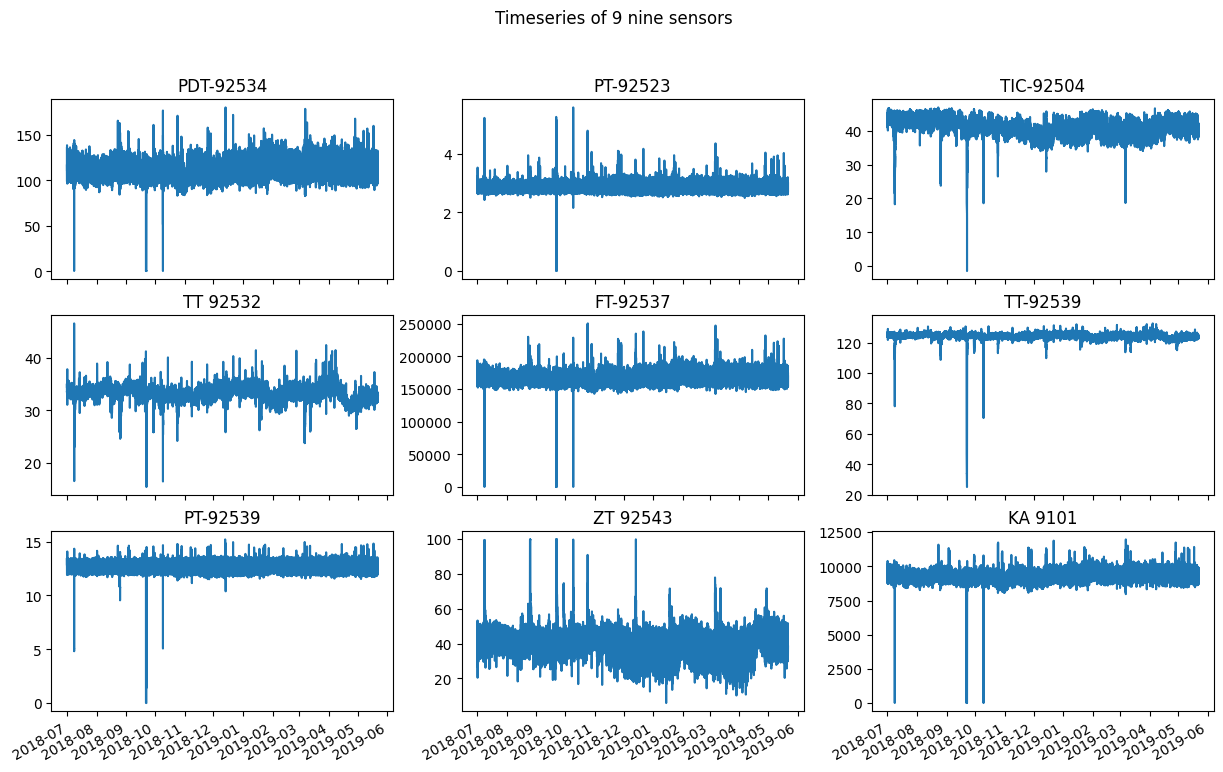

In [16]:
long_dfs_dict = {}

startdate = datetime(2018, 7, 1, tzinfo=timezone.utc)
enddate = datetime(2019, 5, 22, tzinfo=timezone.utc)
today = datetime.today()

for k, v in sensors.items():
    res = c.time_series.data.retrieve_dataframe(id=v, 
                                                start=startdate, 
                                                end=enddate, 
                                                column_names='id',
                                                aggregates=["average"],
                                                granularity="30s",)
    # Need to find a way to grab the unit of the time-series
    long_dfs_dict[k] = res

# plot_sensor_data('PDT-92534', dfs_dict)
plot_all_nine_sensors(long_dfs_dict)


/tmp/ipykernel_7616/1761427744.py:14: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0, method='ffill')
/tmp/ipykernel_7616/1761427744.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, cols, index)


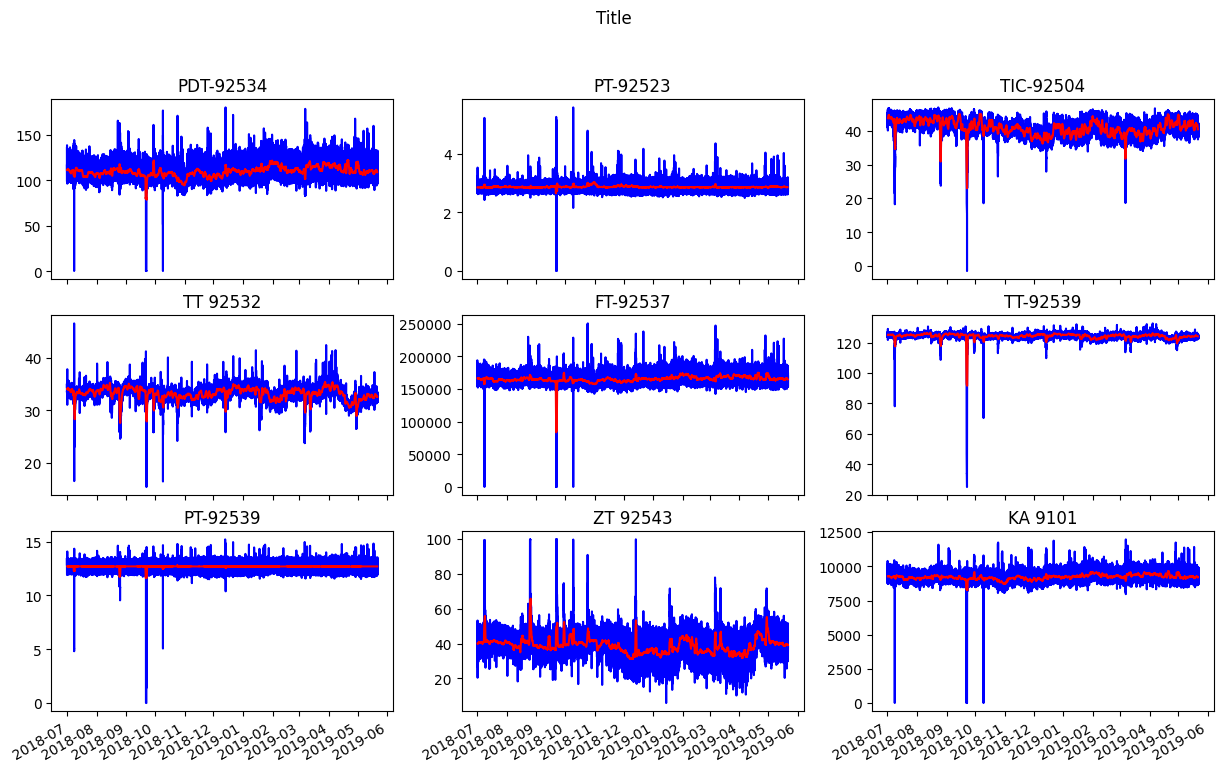

In [17]:
title = 'Title'


plt.figure(figsize=(15, 9))
plt.suptitle(title)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
rows = 3
cols = 3
n = rows * cols
index = 1

for name, df in long_dfs_dict.items():
    df = df.replace(to_replace=0, method='ffill')
    plt.subplot(rows, cols, index)
    index += 1
    decomp = sm.tsa.seasonal_decompose(df, period = 2*60*24)
    plt.plot(df, c='blue')
    plt.plot(decomp.trend.index, decomp.trend, c='red')
    plt.gcf().autofmt_xdate()
    plt.title(name)
plt.show()